# Business Problem
We have sales data for a coffee company in NYC across their 3 areas in Lower Manhattan, Hell's Kitchen, and Astoria. We have data for transaction_qty, unit_price, product_category, and time of purchase. The company wants to find a way to improve sales and learn more about consumer trends. How can we improve cofee sales? 

# Recommendations:
* Transaction quantity was the strongest predictor of sales. Particularly, purchasing 4 or more items strongly impacted sales.
* Coffee beans was the second highest gini importance score. This aligned with findings during data exploration illustrated in outliers above our maximum value in the interquartile range. Having coffee beans available for purchase will continue to yield sales
* Sales peak between opening-10am across all 3 store areas. It would be good to target opportunities during this period.

**Key points**:
* Cross Validation Gradient Boosting yielded the best results. Our r2 score is 90% and the mape was -13.9% suggesting acceptable forecast accuracy. In addition, processing time for a gradient boosting model with hyperparameter tuning was much faster. Hyperparameter tuning a random forest took 20 minutes, but hyperparameter tuning a gradient boosting regressor only took 30 seconds.
* Interestingly, time variables had lower gini scores than I expected. During preprocessing, we saw that there similar distribution of sales across weekday, but there was a skewed distribution across time of day and month.

**Next steps:**
* Reviewing the relationship between product category and sales. product_category for branded, coffee beans, and flavours were also strong predictors of sales.
* Reviewing grouped purchases based on exact purchase times and locations to identify when coffee syrups were bought when coffees were bought. This would be insightful to learn how we can create campaigns for buying flavours when consumers buying their coffee.
* Reviewing how time impacts sales more closely. Time does seem to be important, so I would like to explore forecasting overall sales across date-time to identify any seasonality and see how that may be insightful to predicting at what time is best to create promotions for coffee purchases >= 4. 


In [42]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from xgboost import XGBRegressor, plot_importance
from sklearn.inspection import PartialDependenceDisplay

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/coffee-sales/Coffee Shop Sales.xlsx


In [2]:
data = pd.read_excel('/kaggle/input/coffee-sales/Coffee Shop Sales.xlsx')

# Data Processing

**Steps:**
* Review what variables are available and the output datatypes
* Review if there are any missing or duplicated values that may skew my predictive model
* Conduct exploratory data analysis to glean insight into potential trends and identify useful x/y variables

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149116 entries, 0 to 149115
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   transaction_id    149116 non-null  int64         
 1   transaction_date  149116 non-null  datetime64[ns]
 2   transaction_time  149116 non-null  object        
 3   transaction_qty   149116 non-null  int64         
 4   store_id          149116 non-null  int64         
 5   store_location    149116 non-null  object        
 6   product_id        149116 non-null  int64         
 7   unit_price        149116 non-null  float64       
 8   product_category  149116 non-null  object        
 9   product_type      149116 non-null  object        
 10  product_detail    149116 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(5)
memory usage: 12.5+ MB


In [7]:
data.head()

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
0,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg
1,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg
2,3,2023-01-01,07:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg
3,4,2023-01-01,07:20:24,1,5,Lower Manhattan,22,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm
4,5,2023-01-01,07:22:41,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg


In [4]:
data.isna().sum()
#theres no na values that may skew the available data

transaction_id      0
transaction_date    0
transaction_time    0
transaction_qty     0
store_id            0
store_location      0
product_id          0
unit_price          0
product_category    0
product_type        0
product_detail      0
dtype: int64

In [5]:
data.duplicated().any()
#there are no duplicate values

False

In [10]:
#adding new parameters of time to explore data across and total_cost column 
data['month'] = data['transaction_date'].dt.month
data['monthday'] = data['transaction_date'].dt.day
data['weekday'] = data['transaction_date'].dt.dayofweek
data['hour'] = pd.to_datetime(data['transaction_time'], format='%H:%M:%S').dt.hour
data['sales'] = data['transaction_qty']*data['unit_price']

In [7]:
data.head()

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,month,monthday,weekday,hour,sales
0,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg,1,1,6,7,6.0
1,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,1,1,6,7,6.2
2,3,2023-01-01,07:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg,1,1,6,7,9.0
3,4,2023-01-01,07:20:24,1,5,Lower Manhattan,22,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm,1,1,6,7,2.0
4,5,2023-01-01,07:22:41,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,1,1,6,7,6.2


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

<Axes: title={'center': 'sales over time and stratified by store_locations'}, xlabel='month', ylabel='sales'>

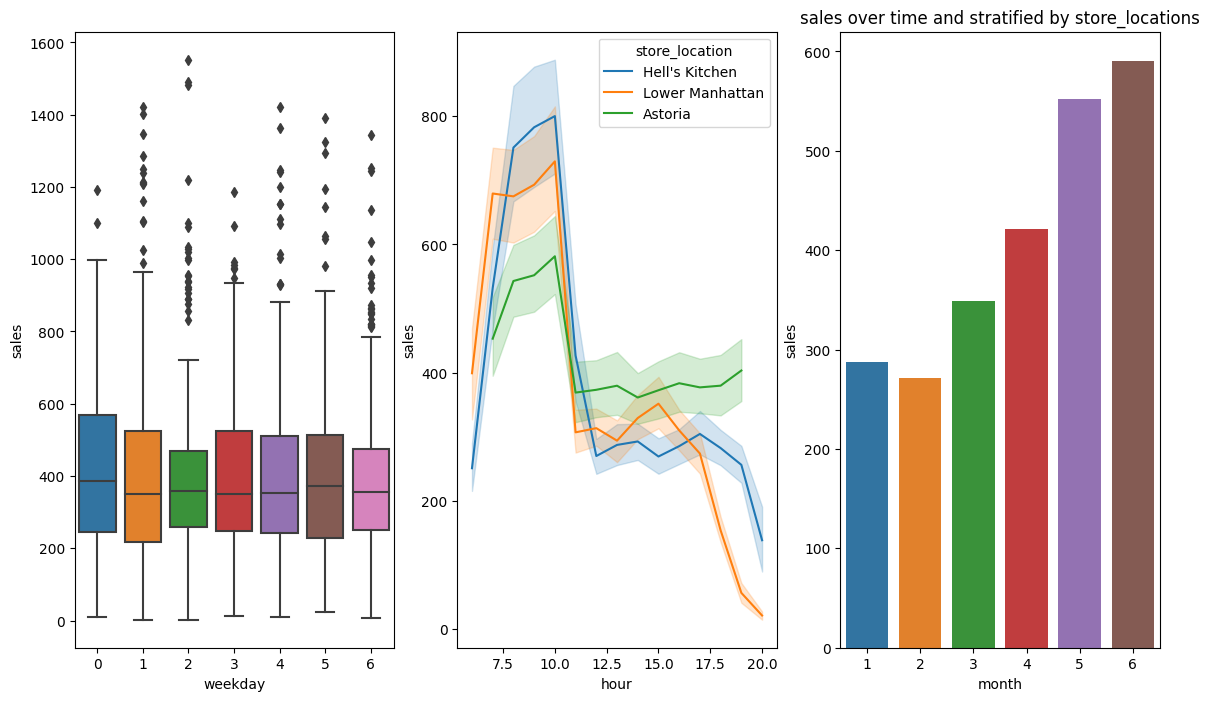

In [8]:
fig,ax = plt.subplots(1,3, figsize=(14,8))
sales_over_time = data[['weekday','hour','month','sales', 'store_location']].groupby(by=['month','weekday','hour','store_location']).sum('sales').reset_index()
sns.boxplot(data=sales_over_time, x='weekday', y='sales', ax=ax[0])
sns.lineplot(data=sales_over_time, x='hour', y='sales', hue='store_location', ax=ax[1], )
plt.title('sales over time and stratified by store_locations')
sns.barplot(data=sales_over_time, x='month', y='sales', ax=ax[2], errorbar=None)
##sales seems to dip on thursdays and peak on saturdays
##distribution of sales over time for each location are different suggesting different sales trends
##data only exists for jan-june

* sales median values are hover around 400 across each weekday with similar iqr across all days except Tuesday
* sales across time of day stratified by location also peak before noon. Around 10am, sales dip. There is a potential relationship between distinct store_location and consumer behavior especially for Astoria. Astoria sales don't have a high peak in the morning and the sales hover around 400 from noon-closing. 
* sales across time also has a right skew indicating potential seasonality or increased consumer behavior towards may and june.

Text(0.5, 1.0, 'transaction_qty across store location')

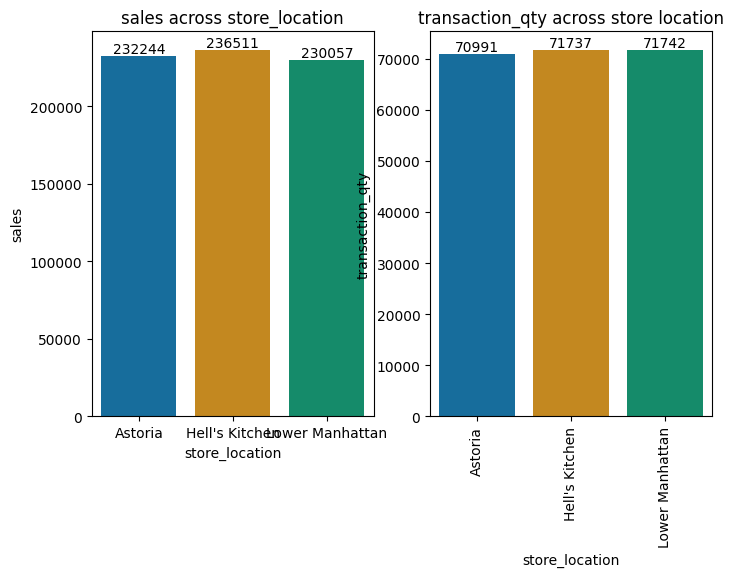

In [28]:
data4 = data[['store_id','store_location','product_id', 'product_type','sales','transaction_qty']].groupby(['store_location']).sum(['sales','transaction_qty']).reset_index()
fig, ax = plt.subplots(1,2, figsize=(8,5))
sns.barplot(data=data4, x='store_location', y='sales', palette='colorblind', ax=ax[0])
ax[0].bar_label(ax[0].containers[0])
ax[0].set_title('sales across store_location')
plt.xticks(rotation=90)
sns.barplot(data=data4, x='store_location', y='transaction_qty', palette='colorblind', ax=ax[1])
ax[1].bar_label(ax[1].containers[0])
ax[1].set_title('transaction_qty across store location')
##theres no visible skew across each location

* looking more closely at distribution of sales and transaction_qty across store_locations, they have similar profits and quantities sold. Store_location may not be a strong predictor for sales. Will keep this in mind as I build my predictive model and choose variables

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Bakery'),
  Text(1, 0, 'Branded'),
  Text(2, 0, 'Coffee'),
  Text(3, 0, 'Coffee beans'),
  Text(4, 0, 'Drinking Chocolate'),
  Text(5, 0, 'Flavours'),
  Text(6, 0, 'Loose Tea'),
  Text(7, 0, 'Packaged Chocolate'),
  Text(8, 0, 'Tea')])

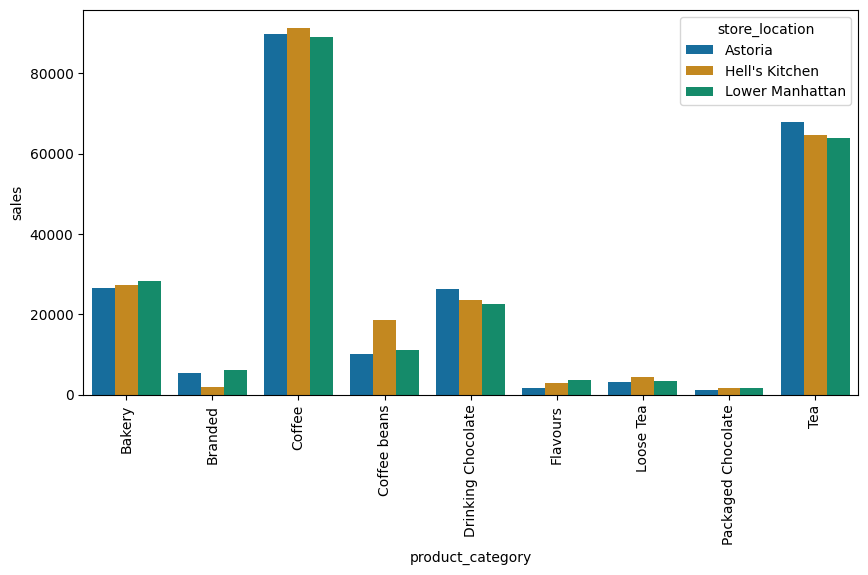

In [23]:
plt.figure(figsize=(10, 5))
data1 = data[['sales','product_category', 'store_location']].groupby(by=['store_location','product_category']).sum(['sales']).reset_index()
sns.barplot(data=data1, x='product_category', y='sales', hue='store_location', palette='colorblind')
plt.xticks(rotation=90)

In [82]:
q1 = data['sales'].quantile(.25)
q3 = data['sales'].quantile(.75)
iqr = q3 - q1 
upper_limit = q3 + 1.5 * iqr
lower_limit = q1 - 1.5 * iqr

outliers = data[(data['sales']<lower_limit) | (data['sales']>upper_limit)]
outliers.groupby('store_location')['sales'].count()
#Lower Manhattan has 2x the outliers than the other 2 locations
outliers[outliers['store_location']=='Lower Manhattan']['product_type'].value_counts(normalize=True)
outliers[(outliers['store_location']=='Lower Manhattan') & (outliers['product_type'])].head()


,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,month,monthday,weekday,hour,sales
3293,3323,2023-01-07,07:44:17,1,5,Lower Manhattan,6,21.00,Coffee beans,Gourmet Beans,Ethiopia,1,7,5,7,21.00
3296,3326,2023-01-07,07:45:15,1,5,Lower Manhattan,9,28.00,Coffee beans,Organic Beans,Organic Decaf Blend,1,7,5,7,28.00
3302,3332,2023-01-07,07:50:42,1,5,Lower Manhattan,9,28.00,Coffee beans,Organic Beans,Organic Decaf Blend,1,7,5,7,28.00
3408,3438,2023-01-07,09:05:19,1,5,Lower Manhattan,9,28.00,Coffee beans,Organic Beans,Organic Decaf Blend,1,7,5,9,28.00
3447,3477,2023-01-07,09:42:52,1,5,Lower Manhattan,7,19.75,Coffee beans,Premium Beans,Jamacian Coffee River,1,7,5,9,19.75


* reviewing outlier values by using the interquartile method. 

In [24]:
data_lm = data[data['store_location']=='Lower Manhattan']
data_hk = data[data['store_location']=="Hell's Kitchen"]
data_a = data[data['store_location']=='Astoria']

data.groupby('store_location')['sales'].describe()
##theres outliers present looking at brief summary. Looking at outliers more closely.
data[data['sales']>300].head()
#there seems to be a routine purchase of premium coffee beans that cause the outliers in sales


,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,month,day,day_name,hour,sales
9310,9340,2023-01-17,09:05:20,8,8,Hell's Kitchen,8,45.0,Coffee beans,Premium Beans,Civet Cat,January,17,Tuesday,9,360.0
9365,9395,2023-01-17,09:55:47,8,8,Hell's Kitchen,8,45.0,Coffee beans,Premium Beans,Civet Cat,January,17,Tuesday,9,360.0
68806,68976,2023-04-17,09:55:47,8,8,Hell's Kitchen,8,45.0,Coffee beans,Premium Beans,Civet Cat,April,17,Monday,9,360.0
68981,69151,2023-04-17,11:18:31,8,8,Hell's Kitchen,8,45.0,Coffee beans,Premium Beans,Civet Cat,April,17,Monday,11,360.0
97979,98233,2023-05-17,09:05:20,8,8,Hell's Kitchen,8,45.0,Coffee beans,Premium Beans,Civet Cat,May,17,Wednesday,9,360.0


In [116]:
stores = ['Lower Manhattan', "Hell's Kitchen", 'Astoria']
data2 = data[['store_id','store_location','product_id', 'product_type','sales']].groupby(['store_location','product_type']).sum('sales').sort_values(by='sales', ascending=False)

def top5(stores):
    data3 = data2.copy()
    
    for i in stores:
        drop_data = data3.loc[[i]][5:].index
        data3 = data3.drop(index=drop_data)
    return data3.sort_values(by=['store_location','sales'], ascending=[True,False] )

top5(stores)

store_id  product_id     sales
store_location  product_type                                         
Astoria         Barista Espresso          14790      192211  27935.00
                Brewed Chai tea           18879      343198  27427.90
                Hot chocolate             12900      255853  26335.25
                Gourmet brewed coffee     18159      184122  23823.30
                Brewed herbal tea         12024      174402  16282.00
Hell's Kitchen  Barista Espresso          49224      305317  32420.20
                Brewed Chai tea           46592      317210  25645.30
                Hot chocolate             30104      224184  23586.25
                Gourmet brewed coffee     45136      172339  23010.10
                Brewed Black tea          30080      186080  15575.50
Lower Manhattan Barista Espresso          26600      248732  31051.00
                Brewed Chai tea           25330      275941  24008.75
                Gourmet brewed coffee     26085      159218  23201.20
                Hot chocolate             17025      202703  22494.50
                Brewed Black tea          18055      178679  16215.50

In [ ]:
##considering products purchased at the same time

transaction_index = []

max_value = len(data.index)-2
for i in range(0, max_value):
    if (data.iloc[[i]]['store_location'].item() == data.iloc[[i+1]]['store_location'].item()) & (data.iloc[[i]]['transaction_time'].item() == data.iloc[[i+1]]['transaction_time'].item()):
        transaction_index.append(i)
        transaction_index.append(i+1)
    else:
        pass
print(transaction_index)

Key results:
* Time of day and month have a skewed distribution, suggesting a potential relationship with sales values. It will be important to include these values as x_variables.
* There is a similar distribution of sales and transaction_qty across store_location, suggesting lesser potential relationship.
* Deciding to use supervised machine learning models doesn't require me to imput outlier variables. However, reviewing the outlier values proved to be interesting (eg sales above $300 were all premium coffee beans. This may be interesting to look further into.
* Reviewing top 5 product_categories by highest profit may be provide further insight into what products have highest sales. Coffee, Tea, and Bakery have the highest sales.


# Predictive Modeling

Steps:
* Choosing to use supervised machine learning models and compare the performance of each model based on hyperparameter tuning and time required to train the model. Specifically, looking at extreme gradient boosting and random forest regressors to identify potential relationships
* Including hyperparameter tuning to identify what parameters yield the best forecasting accuracy
* Including feature engineering to identify what variables impact sales the most

In [14]:
data_new = data[['store_location','month','weekday','hour','sales', 'transaction_qty','product_category']]
x = data_new.drop('sales', axis=1)
x['store_location'] = x['store_location'].map({'Astoria':1, "Hell's Kitchen":2, 'Lower Manhattan':3})
x = pd.get_dummies(x, dtype=np.int8, drop_first=False)
y = data_new['sales']

* during eda, sales over time had a skewed distribution suggesting potential seasonality. Including time as an x_variable
* store_location had similar distribution, but I think it would still be useful to consider as an x_variable. Sales over time of day for each location had slight variaton. In particular, Astoria had slighty different sales over time of day compared to stores in Lower Manhattan and Hell's Kitchen. This is reason enough to keep as x_variables.
* product_category had a skewed distribution of sales. This is worth including as x_variables to uncover potential relationships with sales data 

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=.2, random_state=42)

rfr = RandomForestRegressor(random_state=42)

#hyperparameter tuning
cv_params = {
            'max_depth': [3,6,None],
            'max_features': [1.0],
            'max_samples': [.7, 1.0],
            'min_samples_split': [2,3],
            'n_estimators': [300]
            }


scoring = {'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'r2'}

rfr1 = GridSearchCV(rfr, cv_params, scoring=scoring, cv=4, refit='r2')

In [16]:
%%time
rfr1.fit(x_train, y_train)

CPU times: user 20min 24s, sys: 6.05 s, total: 20min 30s
Wall time: 20min 30s


GridSearchCV(cv=4, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [3, 6, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0], 'min_samples_split': [2, 3],
                         'n_estimators': [300]},
             refit='r2',
             scoring={'neg_mean_absolute_error',
                      'neg_mean_absolute_percentage_error',
                      'neg_mean_squared_error', 'r2'})

* hyperparameter tuning for cross validation for the random forest regressor took 20 minutes to process. That is much longer than desired, so I will be comparing results with cross validated extreme gradient boosting to improve processing time and potentially forecasting accuracy

In [33]:
print('rfr1 best score:', rfr1.best_score_, '\n',
     'rfr1 best params:', rfr1.best_params_)

rfr1 best score: 0.8902014036309729 
 rfr1 best params: {'max_depth': None, 'max_features': 1.0, 'max_samples': 0.7, 'min_samples_split': 3, 'n_estimators': 300}


In [68]:
def make_results(model_name:str, model_object, metric:str):
    
    metric_dict = {'mae': 'mean_test_neg_mean_absolute_error',
                 'mse': 'mean_test_neg_mean_squared_error',
                 'mape': 'mean_test_neg_mean_absolute_percentage_error',
                 'r2': 'mean_test_r2',
                 }

    cv_results = pd.DataFrame(model_object.cv_results_)

    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    mae = best_estimator_results.mean_test_neg_mean_absolute_error
    mse = best_estimator_results.mean_test_neg_mean_squared_error
    mape = best_estimator_results.mean_test_neg_mean_absolute_percentage_error
    r2 = best_estimator_results.mean_test_r2

    table = pd.DataFrame({'model': [model_name],
                        'mae': [mae],
                        'mse': [mse],
                        'mape': [mape],
                        'r2': [r2]
                        },
                       )

    return table

results = make_results('RF CV', rfr1, 'r2')
results

,model,mae,mse,mape,r2
0,RF CV,-0.730566,-2.084145,-0.14591,0.890201


In [69]:
y_pred = rfr1.predict(x_test)

def get_test_scores(model_name:str, y_pred, y_test):
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)

    table = pd.DataFrame({'model': [model_name],
                        'mae': [mae],
                        'mse': [mse],
                        'mape': [mape],
                        'r2': [r2]
                        })

    return table

rfr1_test_scores = get_test_scores('RF test', y_pred, y_test)
results = pd.concat([results, rfr1_test_scores], axis=0)
results

,model,mae,mse,mape,r2
0,RF CV,-0.730566,-2.084145,-0.145910,0.890201
0,RF test,0.729685,2.186754,0.145885,0.760819


In [44]:
xgb = XGBRegressor()

xgb1 = XGBRegressor()
cv_params_xgb = {'max_depth': [2,3,4],
                'learning_rate': [.1],
                'n_estimators':[50,100]}
scoring_xgb = {'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'r2'}
xgb1 = GridSearchCV(xgb1, cv_params_xgb, scoring=scoring_xgb, cv=4, refit='r2')

In [45]:
%%time
xgb.fit(x_train, y_train)

CPU times: user 4.83 s, sys: 12 ms, total: 4.85 s
Wall time: 1.42 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [47]:
%%time
xgb1.fit(x_train, y_train)

CPU times: user 31.2 s, sys: 135 ms, total: 31.3 s
Wall time: 8.01 s


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.1], 'max_depth': [2, 3, 4],
                         'n_estimators': [50, 100]},
             refit='r2',
             scoring={'neg_mean_absolute_error',
                      'neg_mean_absolute_percentage_error',
                      'neg_mean_squared_error', 'r2'})

In [50]:
print(xgb1.best_score_, '\n', xgb1.best_params_)

0.9024980102918168 
 {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}


In [70]:
y_pred_xgb = xgb.predict(x_test)
y_pred_xgb1 = xgb1.predict(x_test)


xgb_test_scores = get_test_scores('XGB test', y_pred_xgb, y_test)
xgb1_results = make_results('XGB CV', xgb1, 'r2')
results = pd.concat([results, xgb1_results, xgb_test_scores], axis=0)
results

,model,mae,mse,mape,r2
0,RF CV,-0.730566,-2.084145,-0.145910,0.890201
0,RF test,0.729685,2.186754,0.145885,0.760819
0,XGB CV,-0.688827,-1.851990,-0.139428,0.902498
0,XGB test,0.699532,2.044492,0.140247,0.776379


Key results:
* r2 is an important metric to consider as the proportion of variance in sales explained by our x_variables. 90%+ is desiarable. 
* mape_score is a measure of prediction accuracy of my forecasting model. The value closest to 0 is desirable.  We were able to decrease it by 1%.

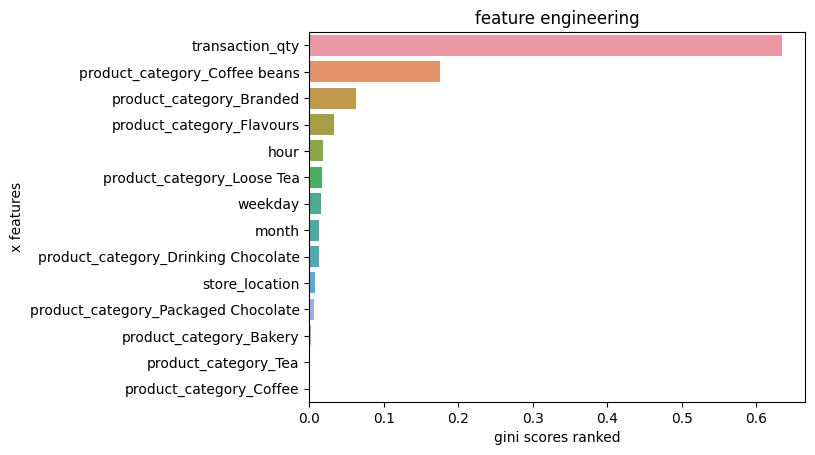

In [71]:
xgb1_importances = pd.DataFrame(xgb1.best_estimator_.feature_importances_, 
                                columns=['gini_importance'],
                                index=x.columns)
xgb1_importances = rfr1_importances[rfr1_importances['gini_importance']>0].sort_values(by='gini_importance', ascending=False)
vis = sns.barplot(data=rfr1_importances, x='gini_importance', y=rfr1_importances.index, orient='h')
vis.set_ylabel('x features')
vis.set_xlabel('gini scores ranked')
vis.set_title('feature engineering')
plt.show()

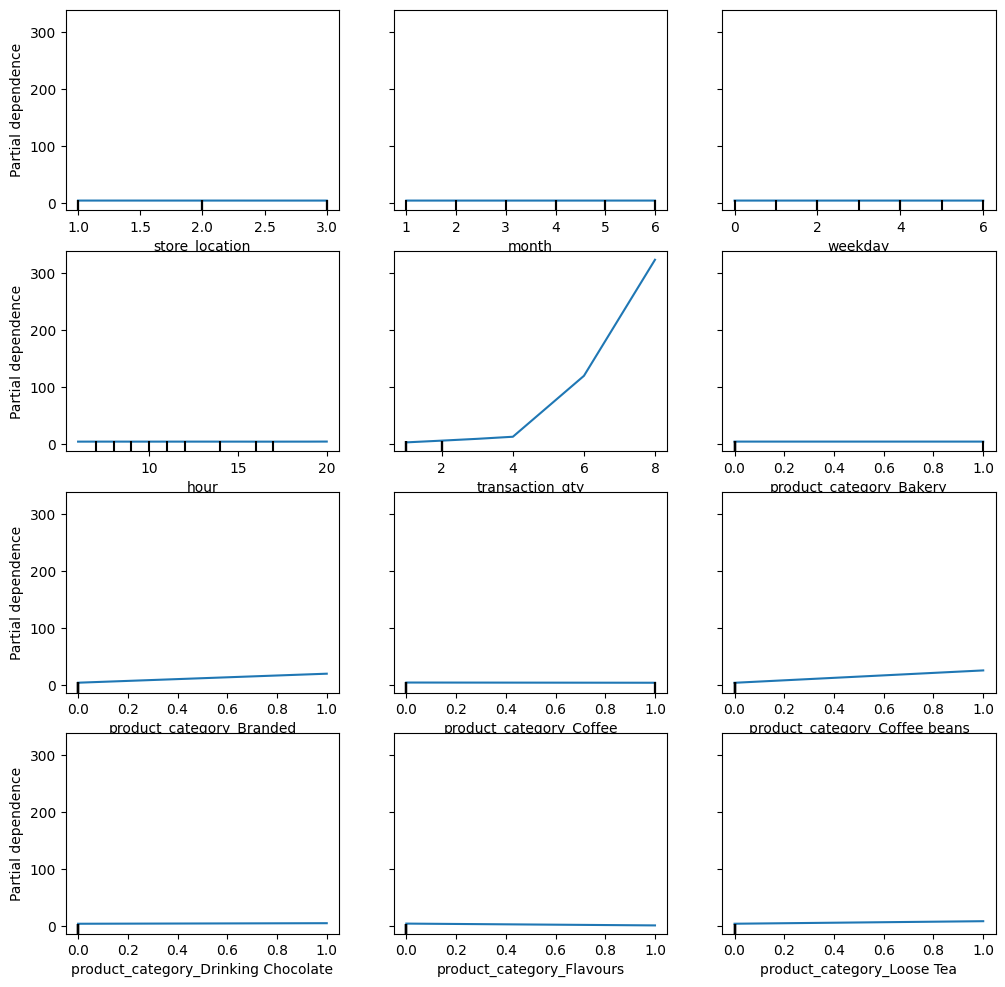

In [77]:
fig, ax = plt.subplots(figsize=(12,12))
PartialDependenceDisplay.from_estimator(xgb1, x_train, range(12), ax=ax)

* interestingly, transaction_qty >= 4 increases the impact on sales.  

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'distribution of residuals')

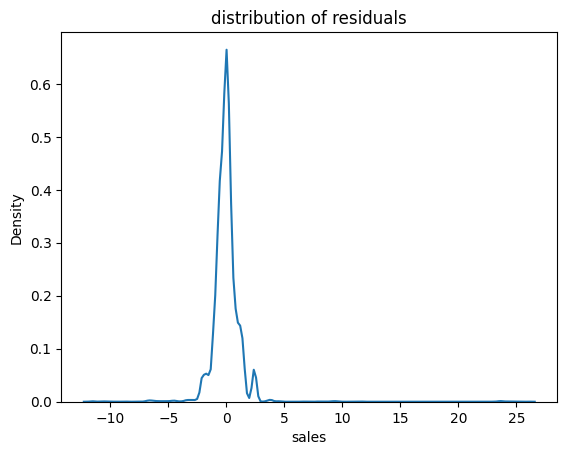

In [107]:
sns.kdeplot((y_test-y_pred_xgb1))
plt.title('distribution of residuals')

* the residuals from our predicted values are normally distributed indicating the model is not biased

In [75]:
results

,model,mae,mse,mape,r2
0,RF CV,-0.730566,-2.084145,-0.145910,0.890201
0,RF test,0.729685,2.186754,0.145885,0.760819
0,XGB CV,-0.688827,-1.851990,-0.139428,0.902498
0,XGB test,0.699532,2.044492,0.140247,0.776379
